In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pickle
import math 
import time 
import datetime
import glob
 
from Helpers import save_to_disk, load_from_disk 
from DatasetHelpers import create_seq_to_datapoint_ds, seq_to_dp_ds_from_df_list, create_pretrain_ds, pretrain_ds_from_df_list, train_validation_split_ds 


In [2]:
final_data_path = "/Volumes/LaCie/aMessdaten/LoopAR/Final_Filtered_Data/"
final_data_path = "/Users/stefan/Desktop/"
all_data = load_from_disk(final_data_path + "full_filtered_data.pickle")

model_save_path = "./trained_models/"

main_train_epochs = 1
first_finetune_epochs = 1 
second_finetune_epochs = 1 

debug_reduce_data = True

# Extract training data

In [3]:
# Get Westbrueck segments

westbrueck_cnt = 0
autobahn_cnt = 0
countryroad_cnt = 0
mountainroad_cnt = 0 

westbrueck_segments = [] # list of dfs 

for participant in all_data:
    for area in all_data[participant]:
        for segment in all_data[participant][area]:
            
            if area == "Autobahn":
                autobahn_cnt += 1
            if area == "CountryRoad":
                countryroad_cnt += 1
            if area == "MountainRoad":
                mountainroad_cnt += 1
            if area == "Westbrueck":
                westbrueck_cnt += 1
                westbrueck_segments.append(all_data[participant][area][segment])
                

print("Available Segments in Areas:")
print("Autobahn:",autobahn_cnt,"\tWestbrueck:",westbrueck_cnt,"\tCountryRoad:",countryroad_cnt,"\tMountainRoad:",mountainroad_cnt)

Available Segments in Areas:
Autobahn: 364 	Westbrueck: 523 	CountryRoad: 185 	MountainRoad: 372


In [4]:
# Keep only certain features in df 
# Extract feature bounds 
# Keep only certain segments based on max(abs(feature value)) 
# Extract test segment (for later testing)

# (All world coordinates relate not to Unity world space anymore, but to car space)

test_segment_idx = 17
test_segment_data = None

westbrueck_condensed_segments = []
large_values_idx_excluded = []

feature_bound_threshold = 4 # exclude feature with abs values greater than 4, Results for > 100 are almost the same as for > 4

keep_features = ["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z","EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
feature_bounds = {}
current_segment_bounds = {}
for feature in keep_features:
    feature_bounds[feature] = 0
    current_segment_bounds[feature] = 0


for idx, segment in enumerate(westbrueck_segments):
    segment = segment[keep_features]
    
    keep_segment = True
    
    for feature in keep_features:
        current_segment_bounds[feature] = 0

    # collect min/max values per feature 
    for feature in keep_features:
        feature_bound = np.maximum(np.abs(segment[feature].min()),np.abs(segment[feature].max()))
        
        # store current bound 
        if feature_bound > current_segment_bounds[feature]:
            current_segment_bounds[feature] = feature_bound
        
        # Exclude segments with big bounds
        if feature_bound > feature_bound_threshold:
            if idx not in large_values_idx_excluded:
                large_values_idx_excluded.append(idx)
            keep_segment = False
        
    if idx == test_segment_idx:
        print("Extracted test segment data with shape",segment.shape)
        test_segment_data = segment
        continue

    if keep_segment:
        westbrueck_condensed_segments.append(segment)
        
        # update final feature bounds from current bounds
        for feature in keep_features:
            if current_segment_bounds[feature] > feature_bounds[feature]:
                feature_bounds[feature] = current_segment_bounds[feature]
        

print("Excluded number of Westbrueck Segments:", len(large_values_idx_excluded))
print("Kept number of Westbrueck Segments:", len(westbrueck_condensed_segments))

Extracted test segment data with shape (1767, 12)
Excluded number of Westbrueck Segments: 99
Kept number of Westbrueck Segments: 423


In [5]:
# Check for nans 
for df in westbrueck_condensed_segments:
    if df.isnull().values.any():
        print("Found NaNs")
        break

In [6]:
feature_bounds

{'HmdPosition.x': 3.6055908203125,
 'HmdPosition.y': 1.6842193603515625,
 'HmdPosition.z': 2.609619140625,
 'NoseVector.x': 0.9996606007100145,
 'NoseVector.y': 0.8368004900723452,
 'NoseVector.z': 0.9999999999533711,
 'EyePosWorldCombined.x': 3.7421112060546875,
 'EyePosWorldCombined.y': 1.69110107421875,
 'EyePosWorldCombined.z': 2.614990234375,
 'EyeDirWorldCombined.x': 0.999987858555089,
 'EyeDirWorldCombined.y': 0.9978489911694244,
 'EyeDirWorldCombined.z': 0.9999999999533711}

In [7]:
# Normalize data  

if True:
    print("Using normalized data")
    for df in westbrueck_condensed_segments:
        for feature in keep_features:
            df.loc[:,feature] = df[feature] / np.ceil(feature_bounds[feature])

    for feature in keep_features:
        test_segment_data.loc[:,feature] = test_segment_data[feature] / np.ceil(feature_bounds[feature])
else:
    print("Using data without normalization")


Using normalized data


/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [8]:
test_segment_data.abs().max()

HmdPosition.x            0.145309
HmdPosition.y            0.550781
HmdPosition.z            0.161560
NoseVector.x             0.157107
NoseVector.y             0.204073
NoseVector.z             0.990894
EyePosWorldCombined.x    0.144699
EyePosWorldCombined.y    0.552841
EyePosWorldCombined.z    0.153198
EyeDirWorldCombined.x    0.610110
EyeDirWorldCombined.y    0.353685
EyeDirWorldCombined.z    0.999922
dtype: float64

In [9]:
if debug_reduce_data:
    westbrueck_condensed_segments = westbrueck_condensed_segments[:1]

# Generate Datasets

In [10]:
input_feature_dim = 6
seq_slice_len = 200
batch_size = 64
do_size_log = False
shuffle = True
shuffle_buffer = 2048
val_frac = 0.1

# Feature list, all other columns are targets 
feature_list = ["HmdPosition.x", "HmdPosition.y", "HmdPosition.z", "NoseVector.x", "NoseVector.y", "NoseVector.z"]

# Pretrain
westbrueck_pretrain_ds = pretrain_ds_from_df_list(westbrueck_condensed_segments, feature_list, seq_slice_len, mask_mode = "pretrain", batch_size = batch_size, do_size_log = False)
westbrueck_pretrain_train, westbrueck_pretrain_validation = train_validation_split_ds(westbrueck_pretrain_ds, val_frac, shuffle, shuffle_buffer)

# Actual data 
westbrueck_dataset = seq_to_dp_ds_from_df_list(westbrueck_condensed_segments,input_feature_dim, seq_slice_len, True, batch_size, do_size_log = False)
westbrueck_train, westbrueck_validation = train_validation_split_ds(westbrueck_dataset, val_frac, shuffle, shuffle_buffer)





Creating dataset from Dataframe List.

Shuffling dataset
Full Dataset size: 30
Train Dataset size: 27
Validate Dataset size: 3
Creating dataset from Dataframe List.

Shuffling dataset
Full Dataset size: 30
Train Dataset size: 27
Validate Dataset size: 3


# Model

In [11]:
log_debug = False
log_debug_tensor = False
log_debug_masks = False
MASK_IGNORE_VALUE = 0 #-9000 # prob change to sth like 9999, as in Embedding the orig input data is received, wich is not limited to (-1,1)

# info on MultiHeadAttention layer
# https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/MultiHeadAttention
# query: Query Tensor of shape [B, T, dim]
# value: Value Tensor of shape [B, S, dim]
# key:   Optional key Tensor of shape [B, S, dim]
# During call, mask value of 1 indicates attention 
# attention_mask: a boolean mask of shape (B, T, S) 

# input shape should not include batch size 

# Info on positional embeddings
# https://www.tensorflow.org/text/tutorials/transformer#positional_encoding

In [12]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dense_dim
        )
        self.dense_proj = keras.Sequential(                        
            [layers.Dense(dense_dim, activation="tanh"), layers.Dense(embed_dim),]  # activation relu 
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })
        return config
      

    def call(self, inputs, mask=None):
        
        
        if mask is not None:
            #padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32") # dtype int32 
            padding_mask = mask
        
        if log_debug_tensor:
            keras.backend.print_tensor(mask, message = "encoder call: mask")
            keras.backend.print_tensor(padding_mask, message = "encoder call: padding mask")
        
        if log_debug_masks:
            print("Encoder mask")
            print(mask)
            print("Encoder padding mask")
            print(padding_mask)


         
        if log_debug:
            print("Encoder reshaped inputs")
            print(inputs)
        

        (attention_output, attention_scores) = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask, return_attention_scores = True
        )

        if log_debug_masks:
            print("Attention_output")
            print(attention_output) 
            print("attention scors")
            print(attention_scores)
        
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        if log_debug:
            print("Encoder proj_input")
            print(proj_input)
            print("Encoder proj_output")
            print(proj_output)
            print("Encoder Shape")
            print(self.layernorm_2(proj_input + proj_output))
            print()
            
        return self.layernorm_2(proj_input + proj_output)

    
    
class PositionalEmbedding(layers.Layer):
    
    
    def __init__(self, sequence_length, feature_dim, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        # Save init values
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.embed_dim = embed_dim 
        
        # Init dense projection
        # (Only last dim is affected by Dense layer) 
        self.dense_proj = keras.Sequential([layers.Dense((self.feature_dim * self.embed_dim), activation="tanh"),\
                                           keras.layers.Reshape((sequence_length, self.feature_dim * self.embed_dim ))])
        

        # Calculate Positional Embedding 
        self.pos_embed = self._calculate_positional_embedding(self.sequence_length, self.feature_dim * self.embed_dim) 


        if log_debug:
            print("Positional Embedding Shape:")
            print(self.pos_embed.shape)

    def _calculate_positional_embedding(self, position, d_model):

        def get_angles(pos, i, d_model):
            angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
            return pos * angle_rates

        angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                                  np.arange(d_model)[np.newaxis, :],
                                  d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)


    def call(self, inputs):
        

        # Add embedding dimensions  
        inputs = self.dense_proj(inputs)

        
        if log_debug:
            print("Positional Embedding dense projection of inputs:")
            print(inputs)
        
        
        
        # Positional embedding 
        pos_embedding = self.pos_embed
        
        if log_debug:
            print()
            print("Positional Embedding Return Value")
            print(inputs + pos_embedding)
            print()
    

        return inputs + pos_embedding 
        
        
        
    def compute_mask(self, inputs, mask=None):


        return tf.zeros((tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[1])) 

        ##broadcast_shape = [tf.shape(inputs)[0], tf.shape(inputs)[1], self.embed_dim]
        broadcast_shape = [tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[1]]
       
        #np_inp = np.zeros((64,200))
        #np_inp[:,0] = 1
        #to_be_broadcasted = tf.convert_to_tensor(np_inp)
        to_be_broadcasted = tf.math.not_equal(inputs, MASK_IGNORE_VALUE)
        broadcasted = tf.expand_dims(to_be_broadcasted, -1)
        broadcasted = tf.broadcast_to(broadcasted, shape = broadcast_shape)


        if log_debug_tensor:
            keras.backend.print_tensor(mask, message = "positional embedding compute mask: mask")
            keras.backend.print_tensor(tf.math.not_equal(inputs, MASK_IGNORE_VALUE), message = "positional embedding compute mask: return val")
            #keras.backend.print_tensor(tf.zeros(tf.shape(inputs)), message = "positional embedding compute mask: return val")

        return broadcasted
        return tf.math.not_equal(inputs, MASK_IGNORE_VALUE) # mask ignore value was 0 
        

    
    # allow saving 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'feature_dim': self.feature_dim,
            'embed_dim': self.embed_dim
        })
        return config
    
  


In [13]:
def build_transformer_encoder_only_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units, target_is_seq):

    '''
    seq_slice_len:      Length of the sequence (slice, taken from the full sequence)
    feature_dim:        Dimension of input data (i.e. how many times seq_len is included)
    embed_dim:          Dimensions that should be added on top (multiplying size)
    latent_dim:         Internals of transformer
    num_heads:          Internals of transformer 
    num_encoder_units:  Number of encoder units to be stacked 
    target_is_seq:      Is target a full sequence or just one datapoint 
    '''

    # Input of shape (sequence_length, feature_dim)
    # Projected (with additional positional embedding) to shape (sequence_length, feature_dim * embed_dim)
    encoder_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="encoder_inputs") 
    x_encoder = PositionalEmbedding(seq_slice_len, feature_dim = feature_dim, embed_dim = embed_dim)(encoder_inputs)

    if log_debug:
        print("Encoder Inputs:")
        print(encoder_inputs)
        print("Embedded encoder inputs (x_encoder):")
        print(x_encoder)
        print()
        print("Embedded encoder inputs mask")
        print(x_encoder._keras_mask)

    # Transformer Encoder
    encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(x_encoder)

    # Stack more encoders if specified
    for idx in range(num_encoder_units - 1):
        encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(encoder_outputs)

    # Reshape output 
    if target_is_seq:
        dense_outputs = layers.Dense(embed_dim*feature_dim)(encoder_outputs)
        dense_outputs = layers.Dense(feature_dim)(dense_outputs)
        dense_outputs = layers.Reshape((seq_slice_len,feature_dim))(dense_outputs)
    else:
        dense_outputs = layers.Flatten()(encoder_outputs)
        dense_outputs = layers.Dense(feature_dim)(dense_outputs)
        dense_outputs = layers.Reshape((1,feature_dim))(dense_outputs)

    encoder_only = keras.Model(inputs=encoder_inputs, outputs=dense_outputs)
    return encoder_only 


In [14]:
def build_dense_model(seq_slice_len,feature_dim,dense_dim,target_is_seq):
    inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32") 
    flattened = keras.layers.Flatten()(inputs)
    dense = keras.layers.Dense(dense_dim, activation = 'tanh')(flattened)
    dense = keras.layers.Dense(dense_dim, activation = 'tanh')(dense)

    if target_is_seq:
        final = keras.layers.Dense(seq_slice_len * feature_dim, activation = 'tanh')(dense)
        final = keras.layers.Reshape((seq_slice_len,feature_dim))(final)
    else:
        final = keras.layers.Dense(1 * feature_dim, activation = 'tanh')(dense)
        final = keras.layers.Reshape((1,feature_dim))(final)
  
    dense_model = keras.Model(inputs = inputs, outputs = final)

    return dense_model

In [15]:
def build_lstm_bidirectional(seq_slice_len,feature_dim,lstm_units,dense_dim,target_is_seq):
    inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32")
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_units))(inputs)
    dense = keras.layers.Dense(dense_dim, activation = 'tanh')(lstm)
  
    if target_is_seq:
        final = keras.layers.Dense(seq_slice_len * feature_dim, activation = 'tanh')(dense)
        final = keras.layers.Reshape((seq_slice_len,feature_dim))(final)
    else:
        final = keras.layers.Dense(1 * feature_dim, activation = 'tanh')(dense)
        final = keras.layers.Reshape((1,feature_dim))(final)
    
    lstm_model = keras.Model(inputs = inputs, outputs = final)
  
    return lstm_model

In [16]:
def masked_mse(y_true, y_pred, mask):
    '''
    Apply mask to true and to predicted values, i.e. calculate MSE only for values visible through the mask.
    mask value of 1 represent values taken into account for MSE. 
    '''
    
    y_true_masked = tf.math.multiply(y_true, mask)
    y_pred_masked = tf.math.multiply(y_pred, mask)
    
    mse = tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)
    
    return mse

In [17]:
def build_transformer_encoder_masked_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units):
    '''
    Transformer Encoder With Input Masking and masked MSE  
    seq_slice_len:      Length of the sequence (slice, taken from the full sequence)
    feature_dim:        Dimension of input data (i.e. how many times seq_len is included)
    embed_dim:          Dimensions that should be added on top (multiplying size)
    latent_dim:         Internals of transformer
    num_heads:          Internals of transformer 
    num_encoder_units:  Number of encoder units to be stacked  
    '''
    
    # Mask input 
    mask_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="mask_inputs") 

    
    # Input of shape (sequence_length, feature_dim)
    # Pointwise multiplied with mask to blank out some input 
    # Projected (with additional positional embedding) to shape (sequence_length, feature_dim * embed_dim)
    encoder_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="encoder_inputs") 
    
  
    masked_encoder_inputs = keras.layers.Multiply()([encoder_inputs, mask_inputs])
    x_encoder = PositionalEmbedding(seq_slice_len, feature_dim = feature_dim, embed_dim = embed_dim)(masked_encoder_inputs)

    
    if log_debug:
        print("Encoder Inputs:")
        print(encoder_inputs)
        print("Embedded encoder inputs (x_encoder):")
        print(x_encoder)
        print()
        print("Embedded encoder inputs mask")
        print(x_encoder._keras_mask)

    # Transformer Encoder
    encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(x_encoder)

    # Stack more encoders if specified
    for idx in range(num_encoder_units - 1):
        encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(encoder_outputs)

    # Reshape output 
    
    #dense_outputs = layers.Dense(embed_dim*feature_dim)(encoder_outputs)
    dense_outputs = layers.Dense(feature_dim)(encoder_outputs)
    dense_outputs = layers.Reshape((seq_slice_len,feature_dim))(dense_outputs)

    # Generate Model
    encoder_only_pretrain = keras.Model(inputs=[encoder_inputs,mask_inputs], outputs=dense_outputs)
    
    # Add custom masked mse loss 
    # Invert the mask, as for the loss, those values that were 0ed in the input should be considered  
    encoder_only_pretrain.add_loss(masked_mse(encoder_inputs, dense_outputs, 1 - mask_inputs))
    
    return encoder_only_pretrain
    

In [18]:
# seq_len from above
feature_dim = 6 #2 
embed_dim = 2 
latent_dim = 2048
num_heads = 3 #8
num_encoder_units = 1 #2
target_is_seq = False  
dense_dim = 400 
lstm_units = 100

#encoder_only_model = build_transformer_encoder_only_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units, target_is_seq)
#dense_model = build_dense_model(seq_slice_len,feature_dim,dense_dim,target_is_seq)
#lstm_bidir_model = build_lstm_bidirectional(seq_slice_len,feature_dim,lstm_units,dense_dim,target_is_seq)

encoder_only_model_pretrain = build_transformer_encoder_masked_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units)



In [19]:
encoder_only_model_pretrain.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 200, 6)]     0           []                               
                                                                                                  
 mask_inputs (InputLayer)       [(None, 200, 6)]     0           []                               
                                                                                                  
 multiply (Multiply)            (None, 200, 6)       0           ['encoder_inputs[0][0]',         
                                                                  'mask_inputs[0][0]']            
                                                                                                  
 positional_embedding (Position  (None, 200, 12)     84          ['multiply[0][0]']           

In [20]:
use_model_name = "encoder_only_pretrain"
use_real_data = True



if use_model_name == "dense":
    use_model = dense_model
elif use_model_name == "encoder_only":
    use_model = encoder_only_model
elif use_model_name == "lstm_bidir":
    use_model = lstm_bidir_model
elif use_model_name == "encoder_only_pretrain":
    use_model = encoder_only_model_pretrain
    
    
if use_model_name == "encoder_only_pretrain":
    dataset_train = westbrueck_pretrain_train
    dataset_validate = westbrueck_pretrain_validation
elif use_real_data:
    dataset_train = westbrueck_train
    dataset_validate = westbrueck_validation
elif target_is_seq:
    dataset_train = dataset_train_seq_seq
    dataset_validate = dataset_validate_seq_seq
else:
    dataset_train = dataset_train_seq_single
    dataset_validate = dataset_validate_seq_single


tf.keras.backend.clear_session()

use_model.summary()

# use loss specified within the model 
if use_model_name == "encoder_only_pretrain":
    use_model.compile(
        "adam", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
        run_eagerly = False
    )

# use loss specified here 
else:
    use_model.compile(
        "adam", loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
        run_eagerly = True
    )
    

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

use_model.fit(dataset_train, epochs=main_train_epochs, validation_data=dataset_validate) #, callbacks = [reduce_lr])  #, callbacks=[WandbCallback()])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 200, 6)]     0           []                               
                                                                                                  
 mask_inputs (InputLayer)       [(None, 200, 6)]     0           []                               
                                                                                                  
 multiply (Multiply)            (None, 200, 6)       0           ['encoder_inputs[0][0]',         
                                                                  'mask_inputs[0][0]']            
                                                                                                  
 positional_embedding (Position  (None, 200, 12)     84          ['multiply[0][0]']           

# Save & load model

In [21]:
def get_date_time():
    return str(datetime.datetime.now()).replace("-","_").replace(" ","_").replace(":","_").split(".")[0]

In [22]:
full_save_path = model_save_path + use_model_name + "_" + get_date_time() + ".h5"
use_model.save(full_save_path, save_format = "h5" )



In [23]:
glob.glob(model_save_path + use_model_name + "*.*")

['./trained_models/encoder_only_pretrain_2022_04_05_18_42_53.h5',
 './trained_models/encoder_only_pretrain_2022_04_18_15_52_07.h5',
 './trained_models/encoder_only_pretrain_2nd_ft_2022_04_18_16_18_36.h5',
 './trained_models/encoder_only_pretrain_2022_04_05_18_43_20.h5',
 './trained_models/encoder_only_pretrain_modified_2022_04_18_16_03_43.h5',
 './trained_models/encoder_only_pretrain_2022_04_18_16_39_04.h5',
 './trained_models/encoder_only_pretrain_2nd_ft_2022_04_18_16_08_16.h5']

In [24]:
load_model_now = False
if load_model_now:
    custom_objects = {"PositionalEmbedding": PositionalEmbedding, "TransformerEncoder": TransformerEncoder}
    loaded_model = keras.models.load_model(full_save_path, custom_objects = custom_objects)

# Do Fine-Tuning

In [25]:
use_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 200, 6)]     0           []                               
                                                                                                  
 mask_inputs (InputLayer)       [(None, 200, 6)]     0           []                               
                                                                                                  
 multiply (Multiply)            (None, 200, 6)       0           ['encoder_inputs[0][0]',         
                                                                  'mask_inputs[0][0]']            
                                                                                                  
 positional_embedding (Position  (None, 200, 12)     84          ['multiply[0][0]']           

In [26]:
'''
final_pretrained_encoder = None 
if use_model_name == "encoder_only_pretrain":
    
    # load pretrained model, cut off dense head, make main layers untrainable 
    final_pretrained_encoder = tf.keras.models.Sequential(use_model.layers[:-2])
    
    for layer in final_pretrained_encoder.layers:
        layer.trainable = False
    
    # add trainable dense layers 
    final_pretrained_encoder.add(layers.Dense(feature_dim, activation='tanh', trainable = True)) 
    final_pretrained_encoder.add(layers.Flatten())
    final_pretrained_encoder.add(layers.Dense(feature_dim, activation='tanh', trainable = True)) 
    final_pretrained_encoder.add(layers.Reshape((1, feature_dim)))  

    '''

'\nfinal_pretrained_encoder = None \nif use_model_name == "encoder_only_pretrain":\n    \n    # load pretrained model, cut off dense head, make main layers untrainable \n    final_pretrained_encoder = tf.keras.models.Sequential(use_model.layers[:-2])\n    \n    for layer in final_pretrained_encoder.layers:\n        layer.trainable = False\n    \n    # add trainable dense layers \n    final_pretrained_encoder.add(layers.Dense(feature_dim, activation=\'tanh\', trainable = True)) \n    final_pretrained_encoder.add(layers.Flatten())\n    final_pretrained_encoder.add(layers.Dense(feature_dim, activation=\'tanh\', trainable = True)) \n    final_pretrained_encoder.add(layers.Reshape((1, feature_dim)))  \n\n    '

In [27]:
modified_pretrained_encoder = None 
if use_model_name == "encoder_only_pretrain":
    
    # load pretrained model, cut off dense head, make main layers untrainable 
    #final_pretrained_encoder = tf.keras.models.Sequential(use_model.layers[:-2])
    layers = use_model.layers[:-10]
    
    
    for layer in layers:
        layer.trainable = False
    
    last_layer_out = layers[-1].output
    first_dense = tf.keras.layers.Dense(feature_dim * embed_dim, activation="tanh", trainable = True)(last_layer_out)
    flatten = tf.keras.layers.Flatten()(first_dense)
    second_dense = tf.keras.layers.Dense(feature_dim, activation="tanh", trainable = True)(flatten)
    reshape = tf.keras.layers.Reshape((1, feature_dim))(second_dense)
    
    
    
    '''
     # Mask input 
    mask_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="mask_inputs") 

    
    # Input of shape (sequence_length, feature_dim)
    # Pointwise multiplied with mask to blank out some input 
    # Projected (with additional positional embedding) to shape (sequence_length, feature_dim * embed_dim)
    encoder_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="encoder_inputs") 
    
  
    masked_encoder_inputs = keras.layers.Multiply()([encoder_inputs, mask_inputs])
    x_encoder = PositionalEmbedding(seq_slice_len, feature_dim = feature_dim, embed_dim = embed_dim)(masked_encoder_inputs)
    '''
    
    
    
    modified_pretrained_encoder = keras.Model(inputs=use_model.input, outputs=reshape)
    
    '''
    # add trainable dense layers 
    final_pretrained_encoder.add(layers.Dense(feature_dim, activation='tanh', trainable = True)) 
    final_pretrained_encoder.add(layers.Flatten())
    final_pretrained_encoder.add(layers.Dense(feature_dim, activation='tanh', trainable = True)) 
    final_pretrained_encoder.add(layers.Reshape((1, feature_dim)))  
    '''
    

In [28]:

# For finetuning use standard mse 
modified_pretrained_encoder.compile(
    "adam", loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
    run_eagerly = False
)
modified_pretrained_encoder.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 200, 6)]     0           []                               
                                                                                                  
 mask_inputs (InputLayer)       [(None, 200, 6)]     0           []                               
                                                                                                  
 multiply (Multiply)            (None, 200, 6)       0           ['encoder_inputs[0][0]',         
                                                                  'mask_inputs[0][0]']            
                                                                                                  
 positional_embedding (Position  (None, 200, 12)     84          ['multiply[0][0]']           

In [29]:
# First Finetune 

modified_pretrained_encoder.fit(westbrueck_train, epochs=first_finetune_epochs, validation_data=westbrueck_validation) #, callbacks = [reduce_lr])  #, callbacks=[WandbCallback()])

full_save_path = model_save_path + use_model_name + "_finetune1_" + get_date_time() + ".h5"
modified_pretrained_encoder.save(full_save_path, save_format = "h5" )


27/27 [==============================] - 44s 2s/step - loss: 0.1724 - mean_squared_error: 0.1724 - mean_absolute_error: 0.3071 - mean_absolute_percentage_error: 1316.9298 - cosine_proximity: 0.7845 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.1850 - val_mean_absolute_percentage_error: 334.8575 - val_cosine_proximity: 0.9172


In [30]:
# Second finetune 

# Make all layers trainable 
for layer in modified_pretrained_encoder.layers:
    layer.trainable = True
    
# Fine tune with smaller learning rate 
modified_pretrained_encoder.compile(
    optimizer=keras.optimizers.Adam(1e-5), loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
    run_eagerly = False
)
modified_pretrained_encoder.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 200, 6)]     0           []                               
                                                                                                  
 mask_inputs (InputLayer)       [(None, 200, 6)]     0           []                               
                                                                                                  
 multiply (Multiply)            (None, 200, 6)       0           ['encoder_inputs[0][0]',         
                                                                  'mask_inputs[0][0]']            
                                                                                                  
 positional_embedding (Position  (None, 200, 12)     84          ['multiply[0][0]']           

In [31]:
modified_pretrained_encoder.fit(westbrueck_train, epochs=second_finetune_epochs, validation_data=westbrueck_validation) #, callbacks = [reduce_lr])  #, callbacks=[WandbCallback()])



27/27 [==============================] - 113s 4s/step - loss: 0.0617 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 312.3209 - cosine_proximity: 0.9109 - val_loss: 0.1494 - val_mean_squared_error: 0.1494 - val_mean_absolute_error: 0.2726 - val_mean_absolute_percentage_error: 822.0961 - val_cosine_proximity: 0.7474


In [33]:
get_date_time()

'2022_04_18_16_51_58'

In [36]:

full_save_path = model_save_path + use_model_name + "_finetune2_" + get_date_time() + ".h5"
modified_pretrained_encoder.save(full_save_path, save_format = "h5")


RuntimeError: Unable to create link (name already exists)

In [37]:

def decode_single_segment(model, input_sequence, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = False):
    '''
    Input and ground truth sequences should be of shape (feature_dim, sequence_length). 
    Ground_truth can either be a sequence or a single datapoint.
    '''
    
    if use_dummy_mask:
        pred_seq = model.predict([np.array([input_sequence,]), np.ones_like([input_sequence,])]) 
        pred_seq = pred_seq[0]
        
    else:
        pred_seq = model.predict([np.array([input_sequence,])]) 
        pred_seq = pred_seq[0]

    if plot:

        # Plot entire target sequence 
        if target_is_seq:
            for dim in range(input_sequence.shape[1]):
                plt.plot(input_sequence[:,dim], label = "Input {}".format(dim + 1))
                plt.plot(pred_seq[:,dim], label = "Prediction {}".format(dim + 1))

                if ground_truth is not None:
                    plt.plot(ground_truth[:,dim], label = "Ground Truth {}".format(dim + 1))

                plt.legend()
            plt.show()

        # Plot only single datapoint target 
        else: 
            for dim in range(input_sequence.shape[1]):
                plt.plot(input_sequence[:,dim], label = "Input {}".format(dim + 1))
                plt.plot(input_sequence.shape[0], pred_seq[:,dim], 'o', label = "Prediction {}".format(dim + 1))

                if ground_truth is not None:
                    plt.plot(input_sequence.shape[0], ground_truth[dim], 'o', label = "Ground Truth {}".format(dim + 1))
                    pass

                plt.legend()
            plt.show()
      
    

    return pred_seq


def decode_segment_of_sequences(full_sequence, sub_seq_len, model, target_seq = None, plot=False):
  '''
  Full_sequence should have shape (seq_len, feature_dim) 
  The full sequence is window-sliced into sub-sequences. 
  For those, predictions are retrieved.
  The result is then calculated by adding all the predicted sequences together 
  and averaging over the added values. 
  '''

  # Create slices from the full sequence
  ds_slices = tf.keras.utils.timeseries_dataset_from_array(
    data = full_sequence, targets = None, sequence_length = sub_seq_len, sequence_stride=1, sampling_rate=1,
    batch_size=None, shuffle=False, seed=None, start_index=None, end_index=None
    # for data: Axis 0 is expected to be the time dimension.
  )
  numpy_ds_slices = tfds.as_numpy(ds_slices)

  # Init
  full_seq_len = full_sequence.shape[0]
  prediction_shape = None
  full_pred_seq = None 

  # Init division array 
  a = np.arange(1,sub_seq_len)
  b = np.flip(a)
  division_array = np.zeros(full_seq_len)
  division_array += sub_seq_len
  division_array[0:sub_seq_len-1] = a
  division_array[-(sub_seq_len-1):] = b
  

  # Predict for all slices 
  for idx, ds_slice in enumerate(numpy_ds_slices):

    if idx % 10 == 0:
      print(idx, end=" ")


    # Predict 
    predicted_slice = decode_single_segment(model, ds_slice, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = True)
    #predicted_slice = predicted_slice[0]


    # Update prediction shape and init result if in first slice
    if idx == 0:
      prediction_shape = predicted_slice.shape 

      full_pred_seq = np.zeros((full_seq_len, prediction_shape[1]))
      division_array = np.tile(division_array,(prediction_shape[1],1)).T
    
    # Add current slice to full result 
    full_pred_seq[idx:idx+sub_seq_len, :] += predicted_slice


  # Apply division 
  full_pred_seq = np.divide(full_pred_seq, division_array)

  # Plot
  if plot:
    for dim in range(full_pred_seq.shape[1]):
      plt.plot(full_pred_seq[:,dim], label = str("Prediction {}".format(dim + 1)))

    if target_seq is not None:
      for dim in range(target_seq.shape[1]):
        plt.plot(target_seq[:,dim], label = str("Ground truth {}".format(dim + 1)))
    
    plt.legend()
    
   
  return full_pred_seq


def decode_segment_of_single_targets(full_sequence, sub_seq_len, model, target_seq = None, use_dummy_mask = True, plot=False):
  '''
  Full_sequence should have shape (seq_len, feature_dim) 
  The full sequence is window-sliced into sub-sequences. 
  For those, predictions are retrieved.
  The result is then calculated by adding all the predicted sequences together 
  and averaging over the added values. 
  '''

  # Create slices from the full sequence
  ds_slices = tf.keras.utils.timeseries_dataset_from_array(
    data = full_sequence, targets = None, sequence_length = sub_seq_len, sequence_stride=1, sampling_rate=1,
    batch_size=None, shuffle=False, seed=None, start_index=None, end_index=None
    # for data: Axis 0 is expected to be the time dimension.
  )
  numpy_ds_slices = tfds.as_numpy(ds_slices)

  # Init
  full_seq_len = full_sequence.shape[0]
  prediction_shape = None
  full_pred_seq = None 


  # Predict for all slices 
  for idx, ds_slice in enumerate(numpy_ds_slices):

    if idx % 10 == 0:
      print(idx, end=" ")

    # Predict 
    predicted_slice = decode_single_segment(model, ds_slice, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = False)
    predicted_slice = predicted_slice[0]


    # Update prediction shape and init result if in first slice
    if idx == 0:
      prediction_shape = predicted_slice.shape 
      full_pred_seq = np.zeros((full_seq_len, prediction_shape[0]))
    
    # Add current slice to full result 
    full_pred_seq[sub_seq_len + idx - 1, :] += predicted_slice


  # Plot
  if plot:
    for dim in range(full_pred_seq.shape[1]):
      plt.plot(full_pred_seq[:,dim], label = str("Prediction {}".format(dim + 1)))

    if target_seq is not None:
      for dim in range(target_seq.shape[1]):
        plt.plot(target_seq[:,dim], label = str("Ground truth {}".format(dim + 1)))
    
    plt.legend()

  
  return full_pred_seq



In [38]:
test_segment_data

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z
0,-0.022903,0.526825,-0.079753,-0.152667,0.171129,0.973349,-0.017540,0.529060,-0.079102,-0.265104,-0.297813,0.917075
1,0.018467,0.526760,-0.068319,-0.147739,0.171179,0.974100,0.023830,0.528984,-0.067647,-0.260627,-0.297678,0.918402
2,0.018456,0.526764,-0.068278,-0.147353,0.171099,0.974173,0.023819,0.528976,-0.067586,-0.260482,-0.297651,0.918451
3,-0.000412,0.526760,-0.076294,-0.148493,0.170881,0.974038,0.005783,0.529079,-0.078369,-0.283306,-0.322743,0.903092
4,0.019871,0.526745,-0.070516,-0.145259,0.170835,0.974533,0.025871,0.529022,-0.071920,-0.275523,-0.319708,0.906573
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,0.055222,0.526459,-0.112834,0.000426,0.135859,0.990728,0.056900,0.527802,-0.096110,0.128984,-0.027067,0.991277
1763,0.087772,0.529621,-0.101929,-0.001291,0.135932,0.990717,0.089462,0.530968,-0.085205,0.126273,-0.026582,0.991639
1764,0.053612,0.526283,-0.113607,-0.000171,0.136043,0.990703,0.055313,0.527634,-0.096883,0.126387,-0.026069,0.991638
1765,0.019550,0.522961,-0.125102,0.001061,0.135960,0.990714,0.021244,0.524323,-0.108358,0.128383,-0.026506,0.991370


0 10 20 30 40 50 

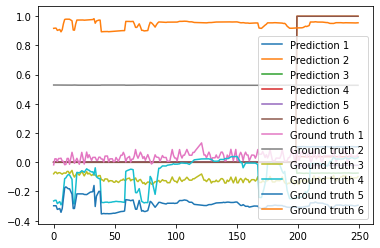

In [39]:

full_sequence_in = test_segment_data.to_numpy()[:250,:6]
full_sequence_target = test_segment_data.to_numpy()[:250,6:]
sub_seq_len = 200

ret = decode_segment_of_single_targets(full_sequence_in, sub_seq_len, modified_pretrained_encoder, target_seq = full_sequence_target, plot=True)


In [40]:
print(len(ret[sub_seq_len - 1:,:]))

51


In [41]:
r2_score(full_sequence_target[-len(ret[sub_seq_len - 1:,:]):],ret[sub_seq_len - 1:,:])

NameError: name 'r2_score' is not defined

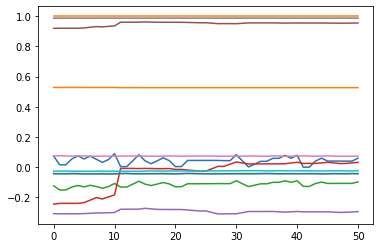

In [66]:
plt.plot(full_sequence_target[-len(ret[sub_seq_len - 1:,:]):])
plt.plot(ret[sub_seq_len - 1:,:])